<a href="https://colab.research.google.com/github/carp-x/ML_Colab/blob/main/celeba/celeba_gan_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 28 01:33:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [ ]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [ ]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
# crop (numpy array) image to given width and height

def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[  starty:starty + new_height, startx:startx + new_width, :]

In [ ]:
# dataset class

class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass

    pass

In [ ]:
# create Dataset object

celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/celeba/celeba_aligned_small.h5py')

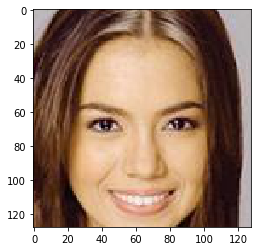

In [ ]:
# check data contains images

celeba_dataset.plot_image(2409)

In [ ]:
# discriminator class

class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

In [ ]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]).to(device))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]).to(device))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 4min 54s, sys: 4.67 s, total: 4min 59s
Wall time: 5min 18s


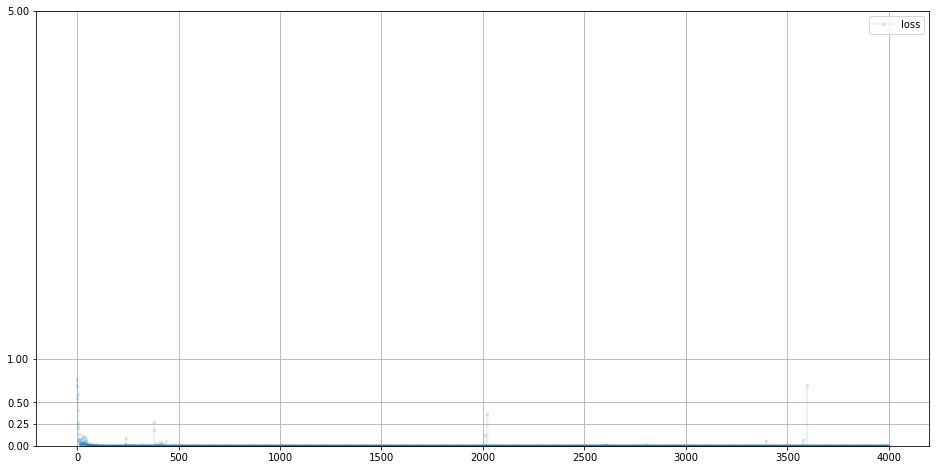

In [ ]:
# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass

1.0
1.0
1.0
1.0
1.880004818488601e-09
2.1278546979974777e-10
6.944802805747274e-12
1.569791407973753e-08


In [ ]:
# generator class

class Generator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(100, 3*11*11),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            # reshape to 4d
            View((1, 3, 11, 11)),

            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2),
            nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),

            # output should be (1,3,128,128)
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)

        # pass onto Discriminator
        d_output = D.forward(g_output)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

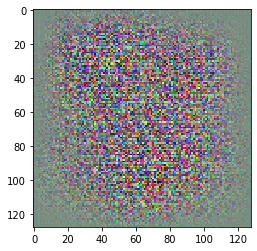

In [ ]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=363, bias=True)
    (1): GELU()
    (2): View()
    (3): ConvTranspose2d(3, 256, kernel_size=(8, 8), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU()
    (6): ConvTranspose2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU()
    (9): ConvTranspose2d(256, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)

In [ ]:
%%time

# train Discriminator and Generator

epochs = 2

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass

epoch =  1
counter =  81000
counter =  82000
counter =  83000
counter =  84000
counter =  85000
counter =  86000
counter =  87000
counter =  88000
counter =  89000
counter =  90000
counter =  91000
counter =  92000
counter =  93000
counter =  94000
counter =  95000
counter =  96000
counter =  97000
counter =  98000
counter =  99000
counter =  100000
counter =  101000
counter =  102000
counter =  103000
counter =  104000
counter =  105000
counter =  106000
counter =  107000
counter =  108000
counter =  109000
counter =  110000
counter =  111000
counter =  112000
counter =  113000
counter =  114000
counter =  115000
counter =  116000
counter =  117000
counter =  118000
counter =  119000
counter =  120000
epoch =  2
counter =  121000
counter =  122000
counter =  123000
counter =  124000
counter =  125000
counter =  126000
counter =  127000
counter =  128000
counter =  129000
counter =  130000
counter =  131000
counter =  132000
counter =  133000
counter =  134000
counter =  135000
counter

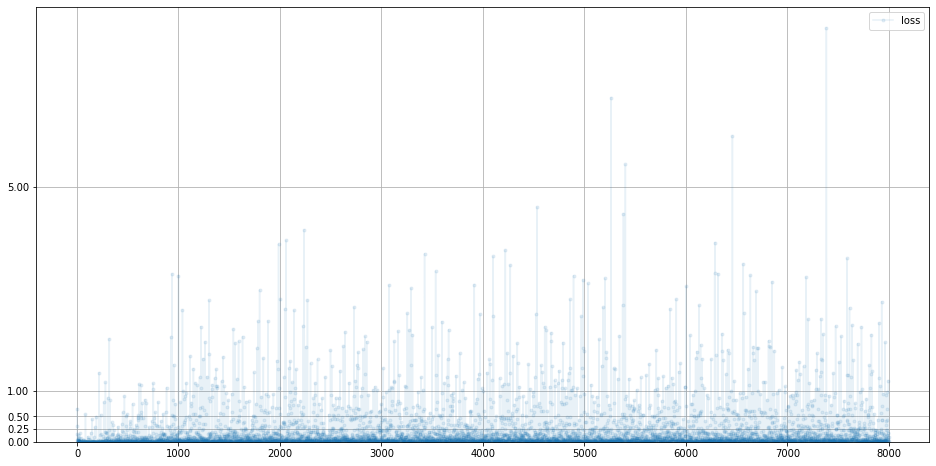

In [ ]:
# plot discriminator error

D.plot_progress()

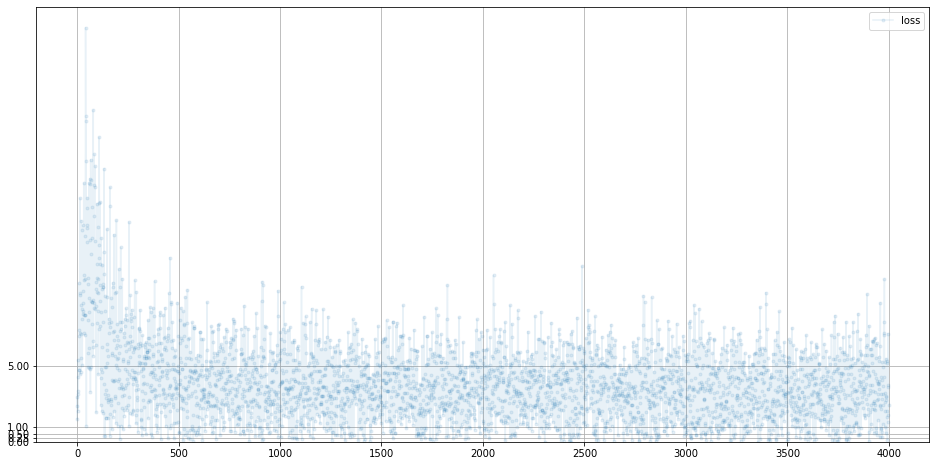

In [ ]:
# plot generator error

G.plot_progress()

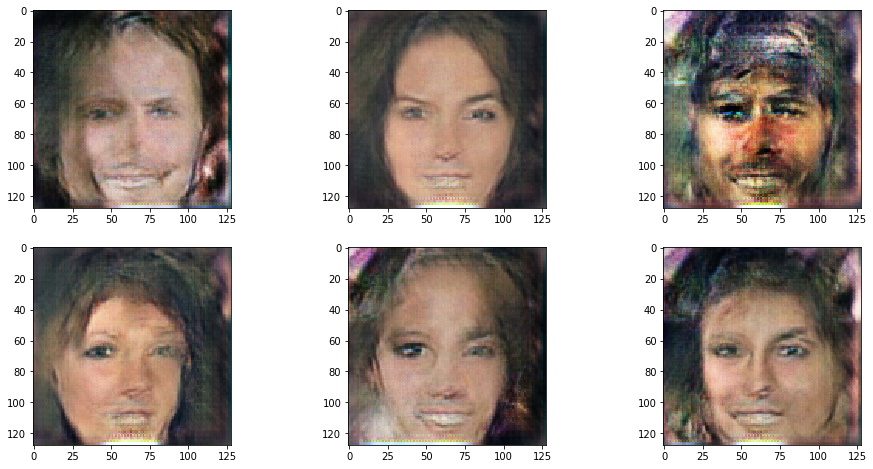

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [ ]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.1442699432373047

In [ ]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.2682504653930664

In [ ]:
# summary of memory consumption

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  151278 KB |  281281 KB |   17595 GB |   17595 GB |
|---------------------------------------------------------------------------|
| Active memory         |  151278 KB |  281281 KB |   17595 GB |   17595 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |  313344 KB |  313344 KB |  313344 KB |       0 B  |
|---------------------------------------------------------------

In [ ]:
torch.save(G, 'Gmodel.pth')

In [ ]:
torch.save(D, 'Dmodel.pth')

In [ ]:
GG = torch.load('Gmodel.pth')

In [ ]:
DD = torch.load('Dmodel.pth')